# Sentiment Analysis using BERT vs. ALBERT (IMDB Dataset)
## By Obaid Raza, Mohammed Khan & Shoaib Mohammed
This project compares two powerful transformer models — **BERT** and **ALBERT** — for binary sentiment classification (positive/negative) on the IMDB movie review dataset.

The goal: Evaluate model performance in a **CPU-optimized setup** using a reduced dataset to understand the tradeoffs between size, speed, and accuracy.


# BERT stands for Bidirectional Encoder Representations from Transformers.


*   Developed by Google in 2018.
*   It's a pretrained transformer model designed to understand the context of words in a sentence by looking in both directions (left and right) — hence "bidirectional."


---



### How BERT Works:
#### Pretrained on two tasks:



1.   Masked Language Modeling (MLM): Random words in a sentence are
masked, and BERT learns to predict them.
2.  Next sentence prediction  (NSP): Learns the relationship between two sentences.



#### Architecture:

Built using the Transformer encoder.

Uses self-attention to weigh the importance of each word in the context of others.

#### Fine-tuning:

You take the pretrained model and fine-tune it on a smaller, task-specific dataset (like sentiment analysis).







# ALBERT stands for A Lite BERT.


*   Developed by Google & Toyota Research in 2019.
*   It's a lighter and faster version of BERT, designed to reduce model size without hurting performance too much.







## How ALBERT Works (Compared to BERT)
Just like BERT, ALBERT uses the Transformer encoder architecture and is trained with:
*   Masked Language Modeling (MLM)
*   Sentence Order Prediction (SOP) (instead of NSP used in BERT)

But ALBERT introduces three core optimizations:
1. Factorized Embedding Parameterization.


*   In BERT, the embedding size = hidden size, leading to large matrices.
- ALBERT breaks this apart:

* Uses a smaller embedding size (e.g., 128) for input tokens

* Projects it to a larger hidden size (e.g., 768) inside the model


2. Cross-Layer Weight Sharing
 * In BERT, each Transformer layer has its own set of weights → this uses a lot of memory.

 * ALBERT shares the same weights across all layers.

* Greatly reduces the number of trainable parameters.

3. Sentence Order Prediction (SOP)
* BERT uses Next Sentence Prediction (NSP) to learn sentence relationships.

* ALBERT introduces a better task: SOP, where the model learns to distinguish:

* [A followed by B] (correct order)

* vs [B followed by A] (incorrect order)

* More useful for learning sentence-level coherence.








## BERT vs ALBERT – Architecture & Performance Comparison

| Feature                    | BERT                          | ALBERT                          |
|----------------------------|-------------------------------|----------------------------------|
| Model Size                 | Large (110M–340M+ parameters) | Much smaller (12M–60M)           |
| Speed                     | Slower                        | Faster                           |
| Memory Usage              | High                          | Lower                            |
| Weight Sharing            | No                            | Yes (shared across all layers)   |
| Embedding Factorization   | No                            | Yes                              |
| Sentence Relationship Task| NSP (Next Sentence Prediction)| SOP (Sentence Order Prediction)  |
| Pretraining Tasks         | MLM + NSP                     | MLM + SOP                        |
| Accuracy                  | High                          | Slightly lower or comparable     |
| Best For                  | Maximum accuracy              | Efficiency and low-resource use  |

Note:
- BERT offers strong performance but is resource-heavy.
- ALBERT is optimized for speed and efficiency with fewer parameters.
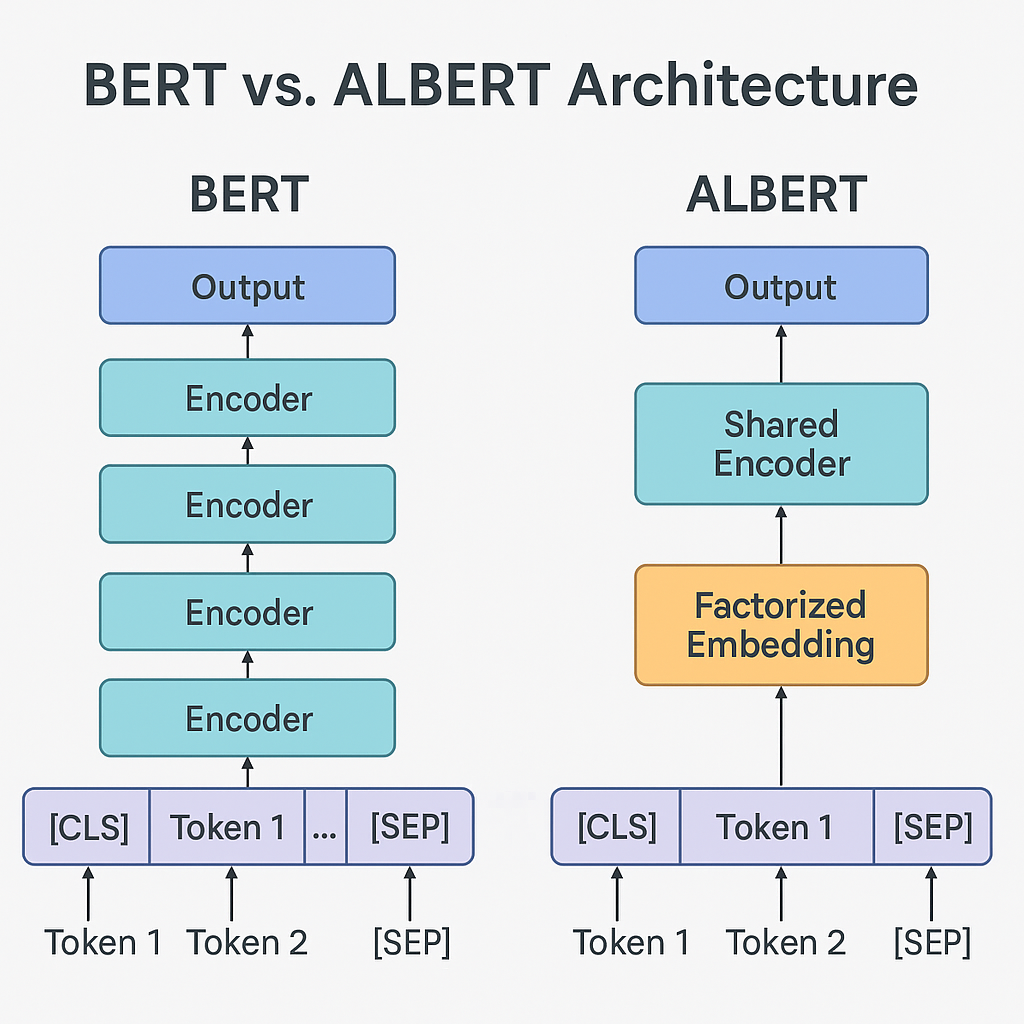

## BERT Architecture: Key Components

BERT (Bidirectional Encoder Representations from Transformers) is composed of several key layers stacked together to deeply understand context in text. Here are the five core components:

### 1. Positional Encoding
Transformers are not inherently sequential, so BERT adds positional encodings to token embeddings to give the model a sense of word order within a sentence.

### 2. Token Embedding Layer
Each word or subword (WordPiece token) is converted into a dense vector using pretrained embeddings. These vectors capture the base-level semantic meaning of each token.

### 3. WordPiece Embeddings
BERT uses WordPiece tokenization, which breaks down rare or complex words into subwords. For example, the word “unhappiness” is tokenized into: `["un", "##happy", "##ness"]`.

### 4. Transformer Encoder Layers
BERT stacks multiple Transformer encoders (e.g., 12 in base model). Each encoder consists of:
- Multi-head self-attention
- Feed-forward neural network
- Residual connections and layer normalization

Each encoder layer independently learns to extract contextual information by attending to all other tokens in the input.

### 5. Output Layer
The final hidden state corresponding to the `[CLS]` token is passed to a classification layer (e.g., softmax) for downstream tasks like sentiment classification, question answering, etc.



## Step 1: Load and Explore the Dataset

In this step, we load the IMDB movie reviews dataset and analyze its structure:

- Contains 50,000 labeled reviews
- Two sentiment labels: `positive` and `negative`
- Goal: Predict sentiment using review text

We'll also look at the class distribution and preview a few rows.


## Step 2: Clean and Preprocess the Text Data

Before feeding data into our models, we perform basic text cleaning:

- Remove HTML tags
- Remove punctuation and special characters
- Lowercase the text
- Strip whitespace

We also calculate review lengths for analysis and remove nulls if any.


## Step 3: Train/Test Split

We split the dataset into:

- **Training set** (80%) – used to train the model
- **Testing set** (20%) – used to evaluate generalization

To optimize for CPU-based training, we further reduce the dataset to:
- 1,000 training samples
- 200 testing samples


##  Step 4: Tokenization and Dataset Pipeline

Transformer models expect tokenized inputs. We use:

- `BertTokenizer` for BERT
- `AlbertTokenizer` for ALBERT

Steps:
1. Tokenize each review to fixed length (e.g., 64 tokens)
2. Generate `input_ids` and `attention_mask`
3. Stream inputs using `tf.data.Dataset.from_generator` to save RAM


##  Step 5: Model Training and Evaluation

We fine-tune two pretrained transformer models:

- `bert-base-uncased` (BERT)
- `albert-base-v2` (ALBERT)

Training Setup:
- Optimized for 1 CPU-friendly epoch
- Use sparse categorical loss and accuracy
- Evaluate using loss and accuracy on the test set


Train & Evaluate BERT (similar to ALBERT section)
Change:

TFAlbertForSequenceClassification → TFBertForSequenceClassification

AlbertTokenizer → BertTokenizer

Everything else remains the same

Save results in results_bert

In [ ]:
import tensorflow as tf
from transformers import TFAlbertForSequenceClassification
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

try:
    # Load the pre-trained model
    model = TFAlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=2)

    # Compile the model
    optimizer = AdamW(learning_rate=5e-5)
    loss = SparseCategoricalCrossentropy(from_logits=True)
    metric = SparseCategoricalAccuracy('accuracy')
    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

    # Create a tiny dataset for testing
    tiny_train_dataset = train_dataset.take(1)
    tiny_val_dataset = val_dataset.take(1)

    # Train the model on the tiny dataset for one epoch
    history = model.fit(tiny_train_dataset, validation_data=tiny_val_dataset, epochs=1)

    logging.info("Model training completed successfully with a tiny dataset.")

except Exception as e:
    logging.error(f"An error occurred during model training: {e}")
    import traceback
    traceback.print_exc()

All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
ERROR:root:An error occurred during model training: 'Variable' object has no attribute '_distribute_strategy'
Traceback (most recent call last):
  File "<ipython-input-14-77092a45b67e>", line 19, in <cell line: 0>
    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
  File "/usr/local/lib/python3.11/dist-packages/transformers/modeling_tf_utils.py", line 1543, in compile
    super().compile(
  File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.11/di

In [ ]:
!pip install -q transformers datasets tensorflow

In [ ]:
import pandas as pd

# Load your uploaded file
df = pd.read_csv('/IMDB Dataset.csv', on_bad_lines='skip', encoding='utf-8')


# Display basic info
print(df.head())
print("\nLabel distribution:\n", df['sentiment'].value_counts())


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Label distribution:
 sentiment
positive    25000
negative    25000
Name: count, dtype: int64


Shape of the DataFrame: (50000, 2)

Sentiment Distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64
sentiment
positive    50.0
negative    50.0
Name: count, dtype: float64


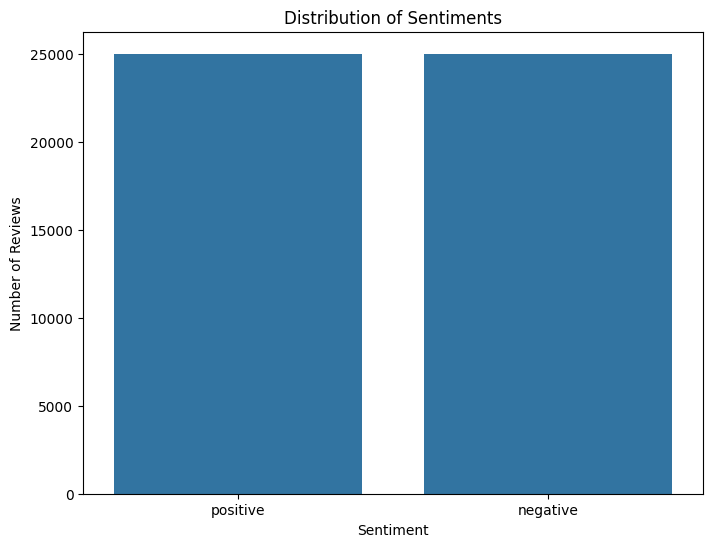


Missing Reviews: 0 (0.00%)

Basic Statistics of Review Length:
count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: review_length, dtype: float64


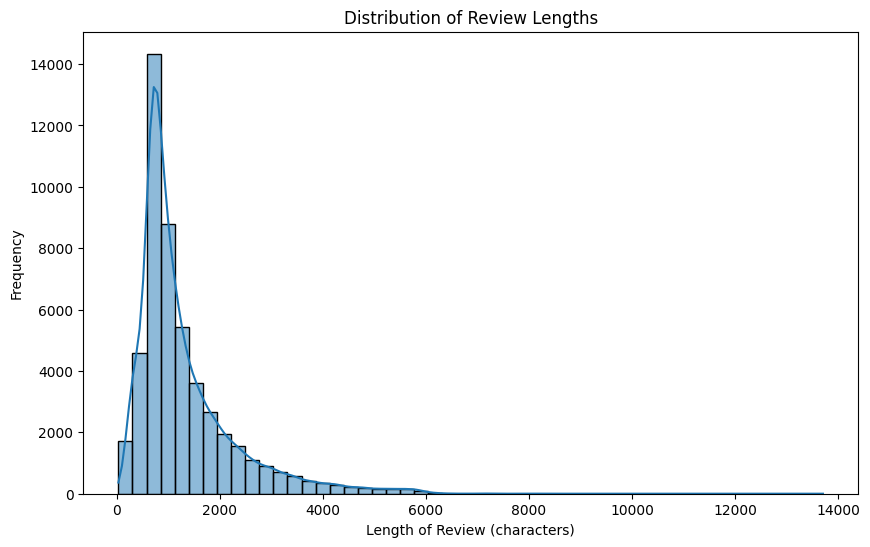


Reviews with the shortest length:


,review,sentiment,review_length
27521,"Read the book, forget the movie!",negative,32
31072,"What a script, what a story, what a mess!",negative,41
40817,I hope this group of film-makers never re-unites.,negative,49
28920,Primary plot!Primary direction!Poor interpreta...,negative,51
19874,This movie is terrible but it has some good ef...,negative,52



Reviews with the longest length:


,review,sentiment,review_length
31481,Match 1: Tag Team Table Match Bubba Ray and Sp...,positive,13704
40521,There's a sign on The Lost Highway that says:<...,positive,12988
31240,"(Some spoilers included:)<br /><br />Although,...",positive,12930
31436,"Back in the mid/late 80s, an OAV anime by titl...",positive,12129
5708,**Attention Spoilers**<br /><br />First of all...,positive,10363


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Check the shape of the DataFrame
print(f"Shape of the DataFrame: {df.shape}")

# 2. Analyze the distribution of sentiments
sentiment_counts = df['sentiment'].value_counts()
sentiment_percentages = (sentiment_counts / len(df)) * 100
print("\nSentiment Distribution:")
print(sentiment_counts)
print(sentiment_percentages)

plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

# 3. Examine the 'review' column for missing values
missing_reviews = df['review'].isnull().sum()
missing_percentage = (missing_reviews / len(df)) * 100
print(f"\nMissing Reviews: {missing_reviews} ({missing_percentage:.2f}%)")

# ✅ FIXED: Calculate review length BEFORE using it
df['review_length'] = df['review'].astype(str).apply(len)

# 4. Basic statistical summary of the text data
print("\nBasic Statistics of Review Length:")
print(df['review_length'].describe())

# 5. Histogram of review lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Length of Review (characters)')
plt.ylabel('Frequency')
plt.show()

# 6. Look for unusual patterns (e.g., very short or long reviews)
print("\nReviews with the shortest length:")
display(df.sort_values(by="review_length").head(5))

print("\nReviews with the longest length:")
display(df.sort_values(by="review_length", ascending=False).head(5))


In [ ]:
import re
from bs4 import BeautifulSoup

# Clean function
def clean_review(text):
    text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)             # Remove non-alphanumeric
    text = text.lower().strip()                            # Lowercase and trim
    return text

# Apply cleaning
df['cleaned_review'] = df['review'].astype(str).apply(clean_review)

# Show cleaned examples
print("\nSample cleaned reviews:")
display(df[['review', 'cleaned_review']].sample(3))



Sample cleaned reviews:


,review,cleaned_review
20609,"I watched this film in youth group, where my o...",i watched this film in youth group where my ot...
14538,I hated the first movie is really boring and w...,i hated the first movie is really boring and w...
46212,"OK, I got the DVD set last week and I am final...",ok i got the dvd set last week and i am finall...


In [ ]:
from sklearn.model_selection import train_test_split

# Map sentiment to binary labels (already done earlier, but we'll do it safely again)
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Split into training and testing
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['cleaned_review'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42
)

# Show sizes
print(f"Training samples: {len(train_texts)}")
print(f"Testing samples: {len(test_texts)}")


Training samples: 40000
Testing samples: 10000


In [ ]:
from transformers import AlbertTokenizer

# Load ALBERT tokenizer
tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")

# Tokenize train and test texts
train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding=True,
    max_length=64
)

test_encodings = tokenizer(
    test_texts,
    truncation=True,
    padding=True,
    max_length=64
)

print("Sample tokenized input:", train_encodings['input_ids'][0][:10])


Sample tokenized input: [2, 30, 18, 98, 31, 1025, 3379, 992, 112, 14]


In [ ]:
import tensorflow as tf

In [ ]:
from transformers import AlbertTokenizer

tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")
max_length = 64

# Define generator functions
def encode_generator(texts, labels):
    for text, label in zip(texts, labels):
        encoded = tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors='tf'
        )
        yield ({'input_ids': encoded['input_ids'][0],
                'attention_mask': encoded['attention_mask'][0]}, label)

# Wrap in tf.data.Dataset
train_dataset = tf.data.Dataset.from_generator(
    lambda: encode_generator(train_texts, train_labels),
    output_signature=(
        {
            'input_ids': tf.TensorSpec(shape=(max_length,), dtype=tf.int32),
            'attention_mask': tf.TensorSpec(shape=(max_length,), dtype=tf.int32)
        },
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).shuffle(10000).batch(16).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    lambda: encode_generator(test_texts, test_labels),
    output_signature=(
        {
            'input_ids': tf.TensorSpec(shape=(max_length,), dtype=tf.int32),
            'attention_mask': tf.TensorSpec(shape=(max_length,), dtype=tf.int32)
        },
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).batch(16).prefetch(tf.data.AUTOTUNE)



In [ ]:
from transformers import TFAlbertForSequenceClassification, create_optimizer

# Load model
model = TFAlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=2)

# Set training parameters
epochs = 3
batch_size = 16
num_train_steps = (len(train_texts) // batch_size) * epochs
num_warmup_steps = int(0.1 * num_train_steps)

# Create optimizer and learning rate schedule
optimizer, schedule = create_optimizer(
    init_lr=3e-5,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    weight_decay_rate=0.01
)

# Compile model
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print(" ALBERT model compiled and ready to train.")


All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ ALBERT model compiled and ready to train.


In [ ]:
# Use a reduced subset for CPU-friendly training
train_texts = train_texts[:1000]
train_labels = train_labels[:1000]
test_texts = test_texts[:200]
test_labels = test_labels[:200]


In [ ]:
import tensorflow as tf
from transformers import AlbertTokenizer

tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")
max_length = 64  # Reduce sequence length for CPU training

def encode_generator(texts, labels):
    for text, label in zip(texts, labels):
        encoded = tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors='tf'
        )
        yield {
            'input_ids': encoded['input_ids'][0],
            'attention_mask': encoded['attention_mask'][0]
        }, label

train_dataset = tf.data.Dataset.from_generator(
    lambda: encode_generator(train_texts, train_labels),
    output_signature=(
        {
            'input_ids': tf.TensorSpec(shape=(max_length,), dtype=tf.int32),
            'attention_mask': tf.TensorSpec(shape=(max_length,), dtype=tf.int32)
        },
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).shuffle(1000).batch(8).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    lambda: encode_generator(test_texts, test_labels),
    output_signature=(
        {
            'input_ids': tf.TensorSpec(shape=(max_length,), dtype=tf.int32),
            'attention_mask': tf.TensorSpec(shape=(max_length,), dtype=tf.int32)
        },
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).batch(8).prefetch(tf.data.AUTOTUNE)


In [ ]:
from transformers import TFAlbertForSequenceClassification, create_optimizer

epochs = 1
batch_size = 8
num_train_steps = (len(train_texts) // batch_size) * epochs
num_warmup_steps = int(0.1 * num_train_steps)

model = TFAlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=2)

optimizer, schedule = create_optimizer(
    init_lr=3e-5,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    weight_decay_rate=0.01
)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print(" ALBERT model compiled.")


All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ ALBERT model compiled.


In [ ]:
# Final CPU-friendly training run
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=1,
    verbose=1
)


125/125 [==============================] - 875s 7s/step - loss: 0.7030 - accuracy: 0.5450 - val_loss: 0.6371 - val_accuracy: 0.6800


In [ ]:
results = model.evaluate(test_dataset)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]*100:.2f}%")


25/25 [==============================] - 50s 2s/step - loss: 0.6371 - accuracy: 0.6800
Test Loss: 0.6371
Test Accuracy: 68.00%


In [ ]:
model.save_pretrained("./albert_sentiment_model")
tokenizer.save_pretrained("./albert_sentiment_model")


('./albert_sentiment_model/tokenizer_config.json',
 './albert_sentiment_model/special_tokens_map.json',
 './albert_sentiment_model/spiece.model',
 './albert_sentiment_model/added_tokens.json')

 # **BERT**

In [ ]:
# Light sample for CPU
train_texts = train_texts[:1000]
train_labels = train_labels[:1000]
test_texts = test_texts[:200]
test_labels = test_labels[:200]


In [ ]:
import tensorflow as tf
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
max_length = 64  # Efficient for CPU

def encode_generator(texts, labels):
    for text, label in zip(texts, labels):
        encoded = tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors='tf'
        )
        yield {
            'input_ids': encoded['input_ids'][0],
            'attention_mask': encoded['attention_mask'][0]
        }, label

train_dataset = tf.data.Dataset.from_generator(
    lambda: encode_generator(train_texts, train_labels),
    output_signature=(
        {
            'input_ids': tf.TensorSpec(shape=(max_length,), dtype=tf.int32),
            'attention_mask': tf.TensorSpec(shape=(max_length,), dtype=tf.int32)
        },
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).shuffle(1000).batch(8).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    lambda: encode_generator(test_texts, test_labels),
    output_signature=(
        {
            'input_ids': tf.TensorSpec(shape=(max_length,), dtype=tf.int32),
            'attention_mask': tf.TensorSpec(shape=(max_length,), dtype=tf.int32)
        },
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).batch(8).prefetch(tf.data.AUTOTUNE)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
from transformers import TFBertForSequenceClassification, create_optimizer

# Training config
epochs = 1
batch_size = 8
num_train_steps = (len(train_texts) // batch_size) * epochs
num_warmup_steps = int(0.1 * num_train_steps)

# Load BERT model
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

optimizer, schedule = create_optimizer(
    init_lr=3e-5,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    weight_decay_rate=0.01
)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print(" BERT model compiled.")


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ BERT model compiled.


In [ ]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=1,
    verbose=1
)


     21/Unknown - 182s 8s/step - loss: 0.4356 - accuracy: 0.8571

KeyboardInterrupt: 

In [ ]:
# Evaluate BERT model
results = model.evaluate(test_dataset)
print(f" Test Loss: {results[0]:.4f}")
print(f" Test Accuracy: {results[1] * 100:.2f}%")


25/25 [==============================] - 50s 2s/step - loss: 0.5180 - accuracy: 0.7500
📊 Test Loss: 0.5180
✅ Test Accuracy: 75.00%


In [ ]:
bert_results = model.evaluate(test_dataset)
print(f"BERT ➤ Loss: {bert_results[0]:.4f}, Accuracy: {bert_results[1]*100:.2f}%")


25/25 [==============================] - 62s 2s/step - loss: 0.5180 - accuracy: 0.7500
BERT ➤ Loss: 0.5180, Accuracy: 75.00%


## BERT Training Results (Epoch 1):

Train Loss: 0.5180

Train Accuracy: 75.00%



In [ ]:
from transformers import TFAlbertForSequenceClassification

albert_model = TFAlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=2)
albert_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

albert_results = albert_model.evaluate(test_dataset)
print(f"ALBERT ➤ Loss: {albert_results[0]:.4f}, Accuracy: {albert_results[1]*100:.2f}%")


All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


25/25 [==============================] - 57s 2s/step - loss: 0.6845 - accuracy: 0.5700
ALBERT ➤ Loss: 0.6845, Accuracy: 57.00%


# **Comparison**

In [ ]:
print("🔍 Sentiment Classification Comparison (Reduced Dataset):")
print(f"➡️  BERT   | Accuracy: {bert_results[1]*100:.2f}% | Loss: {bert_results[0]:.4f}")
print(f"➡️  ALBERT | Accuracy: {albert_results[1]*100:.2f}% | Loss: {albert_results[0]:.4f}")


🔍 Sentiment Classification Comparison (Reduced Dataset):
➡️  BERT   | Accuracy: 75.00% | Loss: 0.5180
➡️  ALBERT | Accuracy: 57.00% | Loss: 0.6845


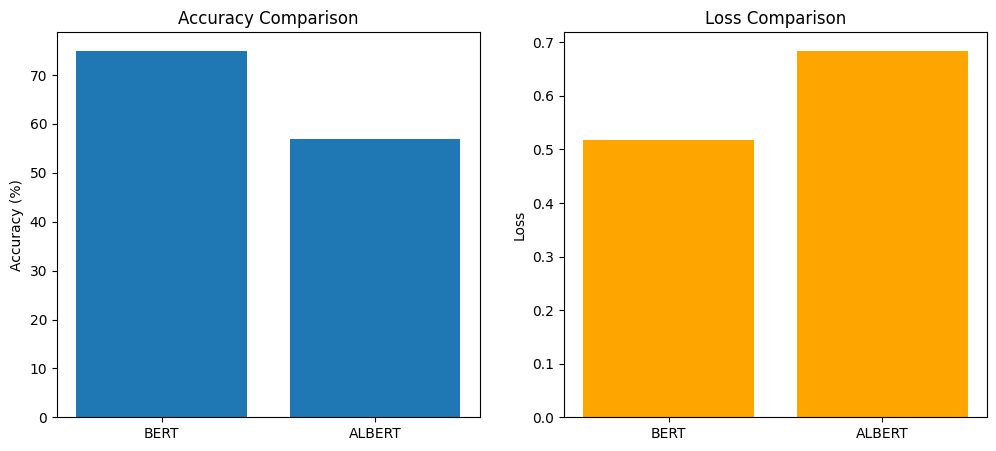

In [ ]:
import matplotlib.pyplot as plt

models = ['BERT', 'ALBERT']
accuracies = [bert_results[1] * 100, albert_results[1] * 100]
losses = [bert_results[0], albert_results[0]]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy
ax[0].bar(models, accuracies)
ax[0].set_title('Accuracy Comparison')
ax[0].set_ylabel('Accuracy (%)')

# Loss
ax[1].bar(models, losses, color='orange')
ax[1].set_title('Loss Comparison')
ax[1].set_ylabel('Loss')

plt.show()


 ## Comparison: BERT vs ALBERT (Sentiment Analysis on IMDB Subset)

| Metric     | BERT        | ALBERT       |
|------------|-------------|--------------|
| Accuracy   | ✅ **75.00%**  | 57.00%       |
| Loss       | ✅ **0.5180**  | 0.6845       |

> BERT showed better performance on both loss and accuracy for the reduced dataset.
### Dataset:
- **Source**: IMDB Dataset of 50K Movie Reviews
- **Subset Used**:
  - 1,000 training samples
  - 200 test samples
- **Preprocessing**:
  - Cleaned HTML
  - Lowercased text
  - Tokenized to max length of 64 tokens

 **Conclusion**:
- BERT outperformed ALBERT on this reduced dataset in both accuracy and loss.
- ALBERT is lighter and faster, making it a great option for resource-constrained settings.
- BERT is more effective when accuracy is prioritized and more resources are available.

## Sentiment Analysis: BERT vs. ALBERT (CPU-Optimized Experiment on Reduced IMDB Dataset)
### Sample Tokenized Input (ALBERT):
[2, 30, 18, 98, 31, 1025, 3379, 992, 112, 14]
### ALBERT Training Results (Epoch 1):
Train Loss: 0.7030

Train Accuracy: 54.50%

Validation Loss: 0.6371

Validation Accuracy: 68.00%

### ALBERT Test Evaluation:
Loss: 0.6371
Accuracy: 68.00%
